# Pitch detection

Compare well-known pitch with [CREPE](https://github.com/maxrmorrison/torchcrepe) and [YIN](https://librosa.org/doc/main/generated/librosa.yin.html) estimates.

In [96]:
import sys
sys.path.append('..')

In [97]:
import warnings
warnings.simplefilter('ignore', RuntimeWarning)
warnings.simplefilter('ignore', UserWarning)

In [98]:
import IPython.display as display
import librosa
import matplotlib.pyplot as plot
import numpy as np

from philharmonia import dataframe, datafile

In [99]:
import torch
import torchcrepe

SR = torchcrepe.SAMPLE_RATE
WS = torchcrepe.WINDOW_SIZE

def crepe(sample):

    x, sr = librosa.load(datafile(sample.file), sr=SR, mono=True)

    roi = dict(fmin=sample.pitch/2, fmax=sample.pitch*2)
    lengths = dict(hop_length=int(100e-3 * sr))

    xt = torch.tensor(x)[None]
    yt = torchcrepe.predict(xt, sample_rate=sr, model='full', **roi, **lengths)
    y = yt.detach().numpy().astype(float)

    return np.mean(y).round(2)

def yin(sample):

    x, sr = librosa.load(datafile(sample.file), sr=SR, mono=True)

    roi = dict(fmin=sample.pitch/2, fmax=sample.pitch*2)
    lengths = dict(hop_length=int(100e-3 * sr), win_length=WS, frame_length=WS*2)
    
    y = librosa.yin(x, sr=sr, **roi, **lengths)

    return np.mean(y).round(2)

def error(x, y):

    y = np.atleast_1d(y)
    e = np.abs(y / x - 1) > 0.5

    return '<--' if np.any(e) else ''

In [100]:
query = [
    "percussion==False",
    "note == 'C'",
    "style == 'normal'",
    "length == '1'",
]

filter = ['file', 'instrument', 'note', 'octave', 'dynamic', 'pitch']
sort = ['pitch', 'dynamic']

data = dataframe().query(' & '.join(query)).filter(filter).sort_values(sort)

data['crepe'] = data.apply(lambda sample: crepe(sample), axis=1)
data['yin'] = data.apply(lambda sample: yin(sample), axis=1)
data['error'] = data.apply(lambda sample: error(sample.pitch, [sample.crepe, sample.yin]), axis=1)

data = data.rename(columns={
    'pitch': 'pitch orig',
    'crepe': 'pitch crepe',
    'yin': 'pitch yin',
    'error': 'octave error'
})

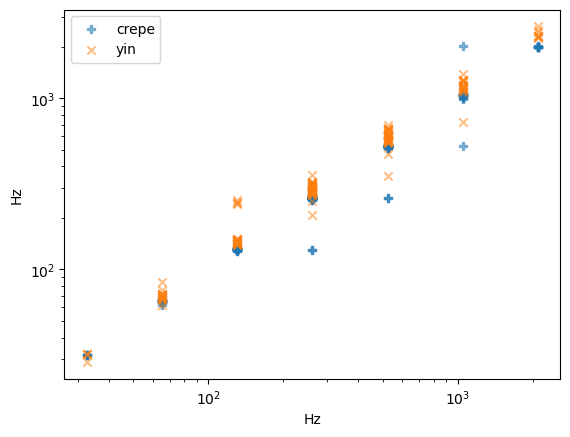

In [112]:
x = data['pitch orig'].tolist()
y1 = data['pitch crepe'].tolist()
y2 = data['pitch yin'].tolist()

plot.scatter(x, y1, label='crepe', marker='P', alpha=0.5)
plot.scatter(x, y2, label='yin', marker='x', alpha=0.5)

plot.legend();
plot.xscale('log');
plot.yscale('log');
plot.xlabel('Hz');
plot.ylabel('Hz');

In [101]:
display.HTML(data.to_html())

,file,instrument,note,octave,dynamic,pitch orig,pitch crepe,pitch yin,octave error
7994,contrabassoon/contrabassoon_C1_1_forte_normal.mp3,contrabassoon,C,1.0,forte,32.70,31.68,32.14,
8166,contrabassoon/contrabassoon_C1_1_fortissimo_normal.mp3,contrabassoon,C,1.0,fortissimo,32.70,31.68,31.86,
8263,contrabassoon/contrabassoon_C1_1_mezzo-forte_normal.mp3,contrabassoon,C,1.0,mezzo-forte,32.70,31.68,32.04,
8191,contrabassoon/contrabassoon_C1_1_piano_normal.mp3,contrabassoon,C,1.0,piano,32.70,31.68,28.66,
4580,bassoon/bassoon_C2_1_forte_normal.mp3,bassoon,C,2.0,forte,65.41,65.70,71.45,
7914,contrabassoon/contrabassoon_C2_1_forte_normal.mp3,contrabassoon,C,2.0,forte,65.41,66.02,67.61,
10554,tuba/tuba_C2_1_forte_normal.mp3,tuba,C,2.0,forte,65.41,64.87,70.26,
4345,bassoon/bassoon_C2_1_fortissimo_normal.mp3,bassoon,C,2.0,fortissimo,65.41,65.62,70.59,
10593,tuba/tuba_C2_1_fortissimo_normal.mp3,tuba,C,2.0,fortissimo,65.41,61.97,65.92,
11742,french horn/french-horn_C2_1_fortissimo_normal.mp3,french-horn,C,2.0,fortissimo,65.41,65.74,68.54,
